In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
meta_cols = ['movie_id', 'title', 'year', 'rating', 'no. votes', 'genres']
meta = pd.read_table(
    './datasets/movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None, names=meta_cols, index_col='movie_id')
def str_to_list(str: str):
    s = str.strip('\'[]')
    return list(set(s.split("\' \'") if s else []))

meta['genre_list'] = meta.genres.apply(str_to_list)

In [5]:
movie_emots = pd.read_pickle('./data/movie_emots')
movie_avg_emots = movie_emots.drop(['text'], axis=1).groupby('movie_id').agg(np.average)
normalized = (movie_avg_emots-movie_avg_emots.mean())/movie_avg_emots.std()
genre_counts = meta.explode('genre_list').genre_list.value_counts()

In [69]:
movie_emots.movie_id.value_counts() >= 50

m289     True
m90      True
m238     True
m435     True
m100     True
        ...  
m456    False
m521    False
m406    False
m270    False
m602    False
Name: movie_id, Length: 617, dtype: bool

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

top_genres = genre_counts.nlargest(5).index
print('top genres:', top_genres.to_list())

def get_genre_sets(X, labels, genres):
    filtered_genres = [[g for g in x if g in genres] for x in labels]
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(filtered_genres)
    return train_test_split(X, y, train_size=0.2, random_state=1) + [mlb]

X = normalized.iloc[:, 0:7]
X_train, X_test, y_train, y_test, mlb = get_genre_sets(
    X, meta.loc[movie_avg_emots.index].genre_list, top_genres)

top genres: ['drama', 'thriller', 'comedy', 'action', 'crime']


In [59]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB

nb_clf = OneVsRestClassifier(GaussianNB())
nb_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=GaussianNB())

In [64]:
from sklearn.metrics import classification_report

def report_clf(clf, X, y, classes):
    y_predict = clf.predict(X)
    return classification_report(
        y,
        y_predict,
        target_names=classes,
        zero_division=1
    )

print(report_clf(nb_clf, X_test, y_test, mlb.classes_))

              precision    recall  f1-score   support

      action       0.39      0.11      0.17       128
      comedy       0.61      0.31      0.41       131
       crime       0.42      0.36      0.39       118
       drama       0.52      0.38      0.44       256
    thriller       0.59      0.67      0.63       215

   micro avg       0.53      0.40      0.46       848
   macro avg       0.51      0.37      0.41       848
weighted avg       0.52      0.40      0.44       848
 samples avg       0.59      0.44      0.39       848



In [67]:
nb_clf.predict(X_test)

array([[0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

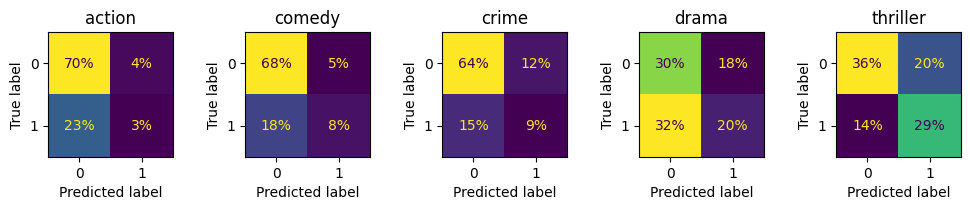

In [65]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay


def show_conf_matrices(X_test, y_test, clf, classes, axs):
    y_predict = clf.predict(X_test)
    i = 0
    for cm in multilabel_confusion_matrix(y_true=y_test, y_pred=y_predict):
        genre = classes[i]
        axs[i].set_title(genre)
        s = cm.sum()
        cm_percent = np.array([[x / s for x in r] for r in cm])
        ConfusionMatrixDisplay(cm_percent).plot(ax=axs[i], colorbar=False, values_format=".0%")
        i += 1

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
show_conf_matrices(X_test, y_test, nb_clf, mlb.classes_, axs)
plt.tight_layout()

In [62]:
from sklearn.svm import LinearSVC, SVC
svc_clf = OneVsRestClassifier(LinearSVC(max_iter=2500))
# svc_clf = OneVsRestClassifier(SVC())
svc_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(max_iter=2500))

              precision    recall  f1-score   support

      action       0.59      0.12      0.21       128
      comedy       0.62      0.22      0.33       131
       crime       0.67      0.03      0.06       118
       drama       0.54      0.55      0.54       256
    thriller       0.63      0.50      0.55       215

   micro avg       0.58      0.35      0.44       848
   macro avg       0.61      0.29      0.34       848
weighted avg       0.60      0.35      0.40       848
 samples avg       0.65      0.43      0.40       848



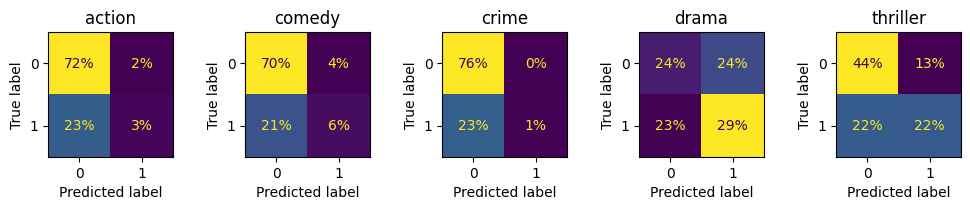

In [63]:
print(report_clf(svc_clf, X_test, y_test, mlb.classes_))
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
show_conf_matrices(X_test, y_test, svc_clf, mlb.classes_, axs)
plt.tight_layout()

In [31]:
from sklearn.linear_model import LogisticRegression

lr_clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
lr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(solver='sag'), n_jobs=1)

              precision    recall  f1-score   support

      action       0.62      0.14      0.23       128
      comedy       0.63      0.24      0.35       131
       crime       0.69      0.08      0.14       118
       drama       0.54      0.55      0.55       256
    thriller       0.62      0.48      0.54       215

   micro avg       0.59      0.36      0.44       848
   macro avg       0.62      0.30      0.36       848
weighted avg       0.61      0.36      0.41       848
 samples avg       0.65      0.44      0.41       848



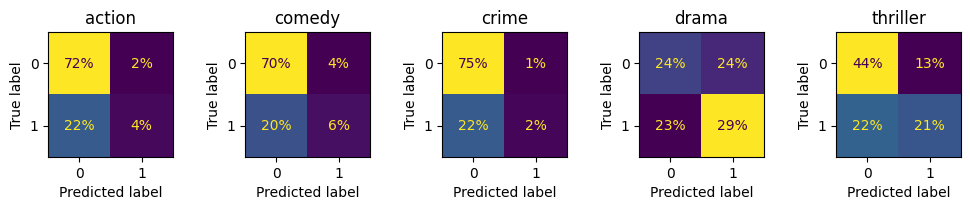

In [32]:
print(report_clf(lr_clf, X_test, y_test, mlb.classes_))
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
show_conf_matrices(X_test, y_test, lr_clf, mlb.classes_, axs)
plt.tight_layout()

In [22]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(tree_method="hist")
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [24]:
xgb_clf.feature_importances_

array([0.14320257, 0.132828  , 0.13611552, 0.13948323, 0.13340382,
       0.13041978, 0.18454711], dtype=float32)

              precision    recall  f1-score   support

      action       0.44      0.33      0.38        45
      comedy       0.40      0.27      0.32        45
       crime       0.32      0.17      0.22        36
       drama       0.62      0.59      0.60        82
    thriller       0.56      0.51      0.53        67

   micro avg       0.52      0.42      0.46       275
   macro avg       0.47      0.37      0.41       275
weighted avg       0.50      0.42      0.45       275
 samples avg       0.57      0.44      0.39       275



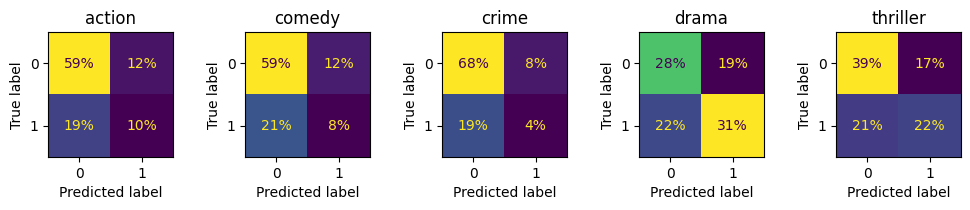

In [23]:
print(report_clf(xgb_clf, X_test, y_test, mlb.classes_))
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
show_conf_matrices(X_test, y_test, xgb_clf, mlb.classes_, axs)
plt.tight_layout()